# Hill Estimator Analysis on SPY ETF Returns

This notebook demonstrates the Hill estimator for tail index estimation using SPY ETF daily returns. We'll:
1. Download SPY price data from Yahoo Finance
2. Compute log returns
3. Estimate tail indices using two k-selection methods
4. Visualize the log survival function with fitted tail lines

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
import sys
import os

# Add src directory to path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))
from hill_estimator import hill_estimator, SelectionMethod, plot_log_survival, plot_hill_diagnostics

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Collection and Processing

In [2]:
# Download SPY data
ticker = "SPY"
start_date = "2000-01-01"
end_date = "2024-01-01"

print(f"Downloading {ticker} data from {start_date} to {end_date}...")
spy_data = yf.download(ticker, start=start_date, end=end_date)

# Calculate log returns
prices = spy_data['Close'].dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"Data shape: {spy_data.shape}")
print(f"Log returns shape: {log_returns.shape}")
print(f"Date range: {log_returns.index[0].date()} to {log_returns.index[-1].date()}")

/tmp/ipykernel_34905/3894416193.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data shape: (6037, 5)
Log returns shape: (6036, 1)
Date range: 2000-01-04 to 2023-12-29


SPY Log Returns Statistics:
Mean: 0.000269
Std: 0.012370
Skewness: -0.2517
Kurtosis: 11.0423
Min: -0.115886
Max: 0.135577


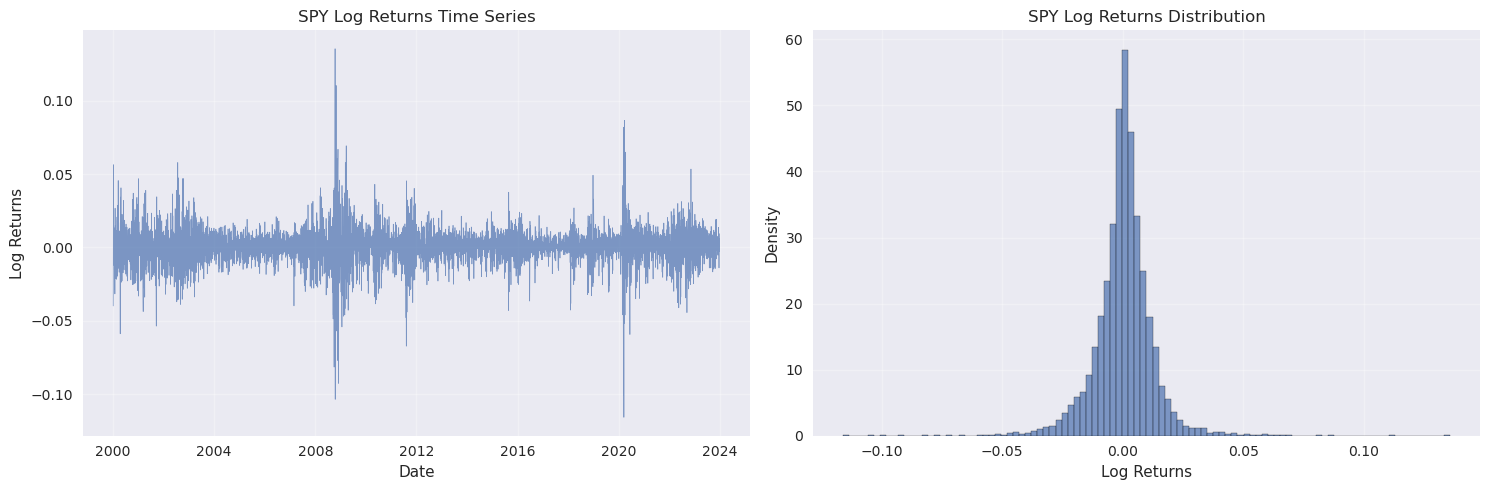

In [3]:
# Basic statistics
print("SPY Log Returns Statistics:")
print(f"Mean: {log_returns['SPY'].mean():.6f}")
print(f"Std: {log_returns['SPY'].std():.6f}")
print(f"Skewness: {stats.skew(log_returns['SPY']):.4f}")
print(f"Kurtosis: {stats.kurtosis(log_returns['SPY']):.4f}")
print(f"Min: {log_returns['SPY'].min():.6f}")
print(f"Max: {log_returns['SPY'].max():.6f}")

# Plot histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Time series plot
ax1.plot(log_returns.index, log_returns, alpha=0.7, linewidth=0.5)
ax1.set_title('SPY Log Returns Time Series')
ax1.set_xlabel('Date')
ax1.set_ylabel('Log Returns')
ax1.grid(True, alpha=0.3)

# Histogram
ax2.hist(log_returns, bins=100, alpha=0.7, density=True, edgecolor='black')
ax2.set_title('SPY Log Returns Distribution')
ax2.set_xlabel('Log Returns')
ax2.set_ylabel('Density')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Hill Estimator Analysis

In [4]:
# Positive tail analysis (right tail)
positive_returns = log_returns[log_returns > 0].dropna().values.flatten()
print(f"Number of positive returns: {len(positive_returns)}")

# Hill estimation for positive tail using GOF method
pos_result_gof = hill_estimator(
    positive_returns, 
    method=SelectionMethod.GOODNESS_OF_FIT,
    k_min=20, 
    k_max=min(500, len(positive_returns)//4)
)

# Hill estimation for positive tail using AMSE method
pos_result_amse = hill_estimator(
    positive_returns, 
    method=SelectionMethod.AMSE_PROXY,
    k_min=20, 
    k_max=min(500, len(positive_returns)//4)
)

print("\nPositive Tail (Right Tail) Analysis:")
print(f"GOF Method: k={pos_result_gof.selection_result.k}, α={pos_result_gof.selection_result.alpha:.4f}, KS={pos_result_gof.selection_result.ks_stat:.4f}")
print(f"AMSE Method: k={pos_result_amse.selection_result.k}, α={pos_result_amse.selection_result.alpha:.4f}, Score={pos_result_amse.selection_result.amse_proxy:.6f}")

Number of positive returns: 3273

Positive Tail (Right Tail) Analysis:
GOF Method: k=481, α=2.4425, KS=0.0335
AMSE Method: k=333, α=2.5646, Score=0.000599


In [5]:
# Negative tail analysis (left tail) - use absolute values
negative_returns = np.abs(log_returns[log_returns < 0].values.flatten())
print(f"Number of negative returns: {len(negative_returns)}")

# Hill estimation for negative tail using GOF method
neg_result_gof = hill_estimator(
    negative_returns, 
    method=SelectionMethod.GOODNESS_OF_FIT,
    k_min=20, 
    k_max=min(500, len(negative_returns)//4)
)

# Hill estimation for negative tail using AMSE method
neg_result_amse = hill_estimator(
    negative_returns, 
    method=SelectionMethod.AMSE_PROXY,
    k_min=20, 
    k_max=min(500, len(negative_returns)//4)
)

print("\nNegative Tail (Left Tail) Analysis:")
print(f"GOF Method: k={neg_result_gof.selection_result.k}, α={neg_result_gof.selection_result.alpha:.4f}, KS={neg_result_gof.selection_result.ks_stat:.4f}")
print(f"AMSE Method: k={neg_result_amse.selection_result.k}, α={neg_result_amse.selection_result.alpha:.4f}, Score={neg_result_amse.selection_result.amse_proxy:.6f}")

Number of negative returns: 6036

Negative Tail (Left Tail) Analysis:
GOF Method: k=255, α=2.8264, KS=0.0374
AMSE Method: k=230, α=2.9428, Score=0.000502


## 3. Hill Curve Visualization

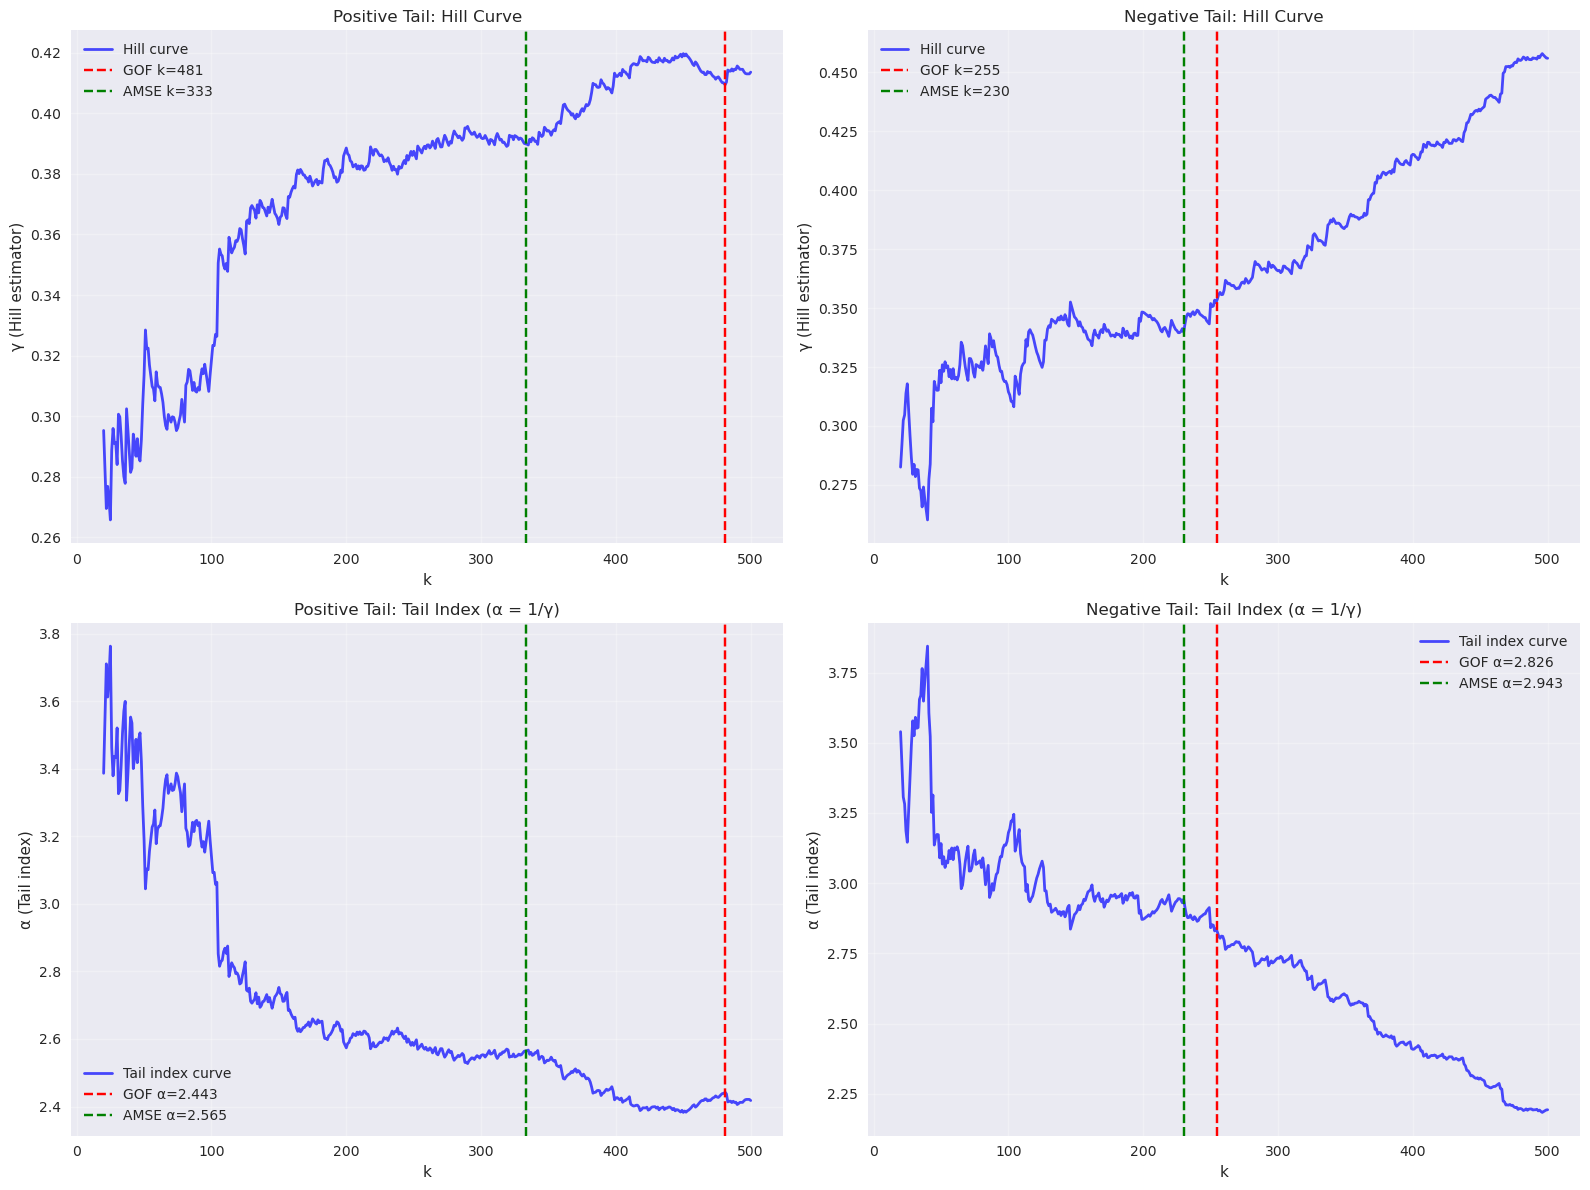

In [6]:
# Plot Hill curves using new diagnostic function
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Positive tail Hill curve (GOF)
k_grid = pos_result_gof.hill_curve.k_grid
gamma_grid = pos_result_gof.hill_curve.hill_gamma

ax1.plot(k_grid, gamma_grid, 'b-', alpha=0.7, linewidth=2, label='Hill curve')
ax1.axvline(pos_result_gof.selection_result.k, color='red', linestyle='--', 
           label=f"GOF k={pos_result_gof.selection_result.k}")
ax1.axvline(pos_result_amse.selection_result.k, color='green', linestyle='--', 
           label=f"AMSE k={pos_result_amse.selection_result.k}")
ax1.set_xlabel('k')
ax1.set_ylabel('γ (Hill estimator)')
ax1.set_title('Positive Tail: Hill Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Negative tail Hill curve
k_grid_neg = neg_result_gof.hill_curve.k_grid
gamma_grid_neg = neg_result_gof.hill_curve.hill_gamma

ax2.plot(k_grid_neg, gamma_grid_neg, 'b-', alpha=0.7, linewidth=2, label='Hill curve')
ax2.axvline(neg_result_gof.selection_result.k, color='red', linestyle='--', 
           label=f"GOF k={neg_result_gof.selection_result.k}")
ax2.axvline(neg_result_amse.selection_result.k, color='green', linestyle='--', 
           label=f"AMSE k={neg_result_amse.selection_result.k}")
ax2.set_xlabel('k')
ax2.set_ylabel('γ (Hill estimator)')
ax2.set_title('Negative Tail: Hill Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Alpha curves (1/gamma)
ax3.plot(k_grid, 1/gamma_grid, 'b-', alpha=0.7, linewidth=2, label='Tail index curve')
ax3.axvline(pos_result_gof.selection_result.k, color='red', linestyle='--', 
           label=f"GOF α={pos_result_gof.selection_result.alpha:.3f}")
ax3.axvline(pos_result_amse.selection_result.k, color='green', linestyle='--', 
           label=f"AMSE α={pos_result_amse.selection_result.alpha:.3f}")
ax3.set_xlabel('k')
ax3.set_ylabel('α (Tail index)')
ax3.set_title('Positive Tail: Tail Index (α = 1/γ)')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4.plot(k_grid_neg, 1/gamma_grid_neg, 'b-', alpha=0.7, linewidth=2, label='Tail index curve')
ax4.axvline(neg_result_gof.selection_result.k, color='red', linestyle='--', 
           label=f"GOF α={neg_result_gof.selection_result.alpha:.3f}")
ax4.axvline(neg_result_amse.selection_result.k, color='green', linestyle='--', 
           label=f"AMSE α={neg_result_amse.selection_result.alpha:.3f}")
ax4.set_xlabel('k')
ax4.set_ylabel('α (Tail index)')
ax4.set_title('Negative Tail: Tail Index (α = 1/γ)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Log Survival Function Analysis

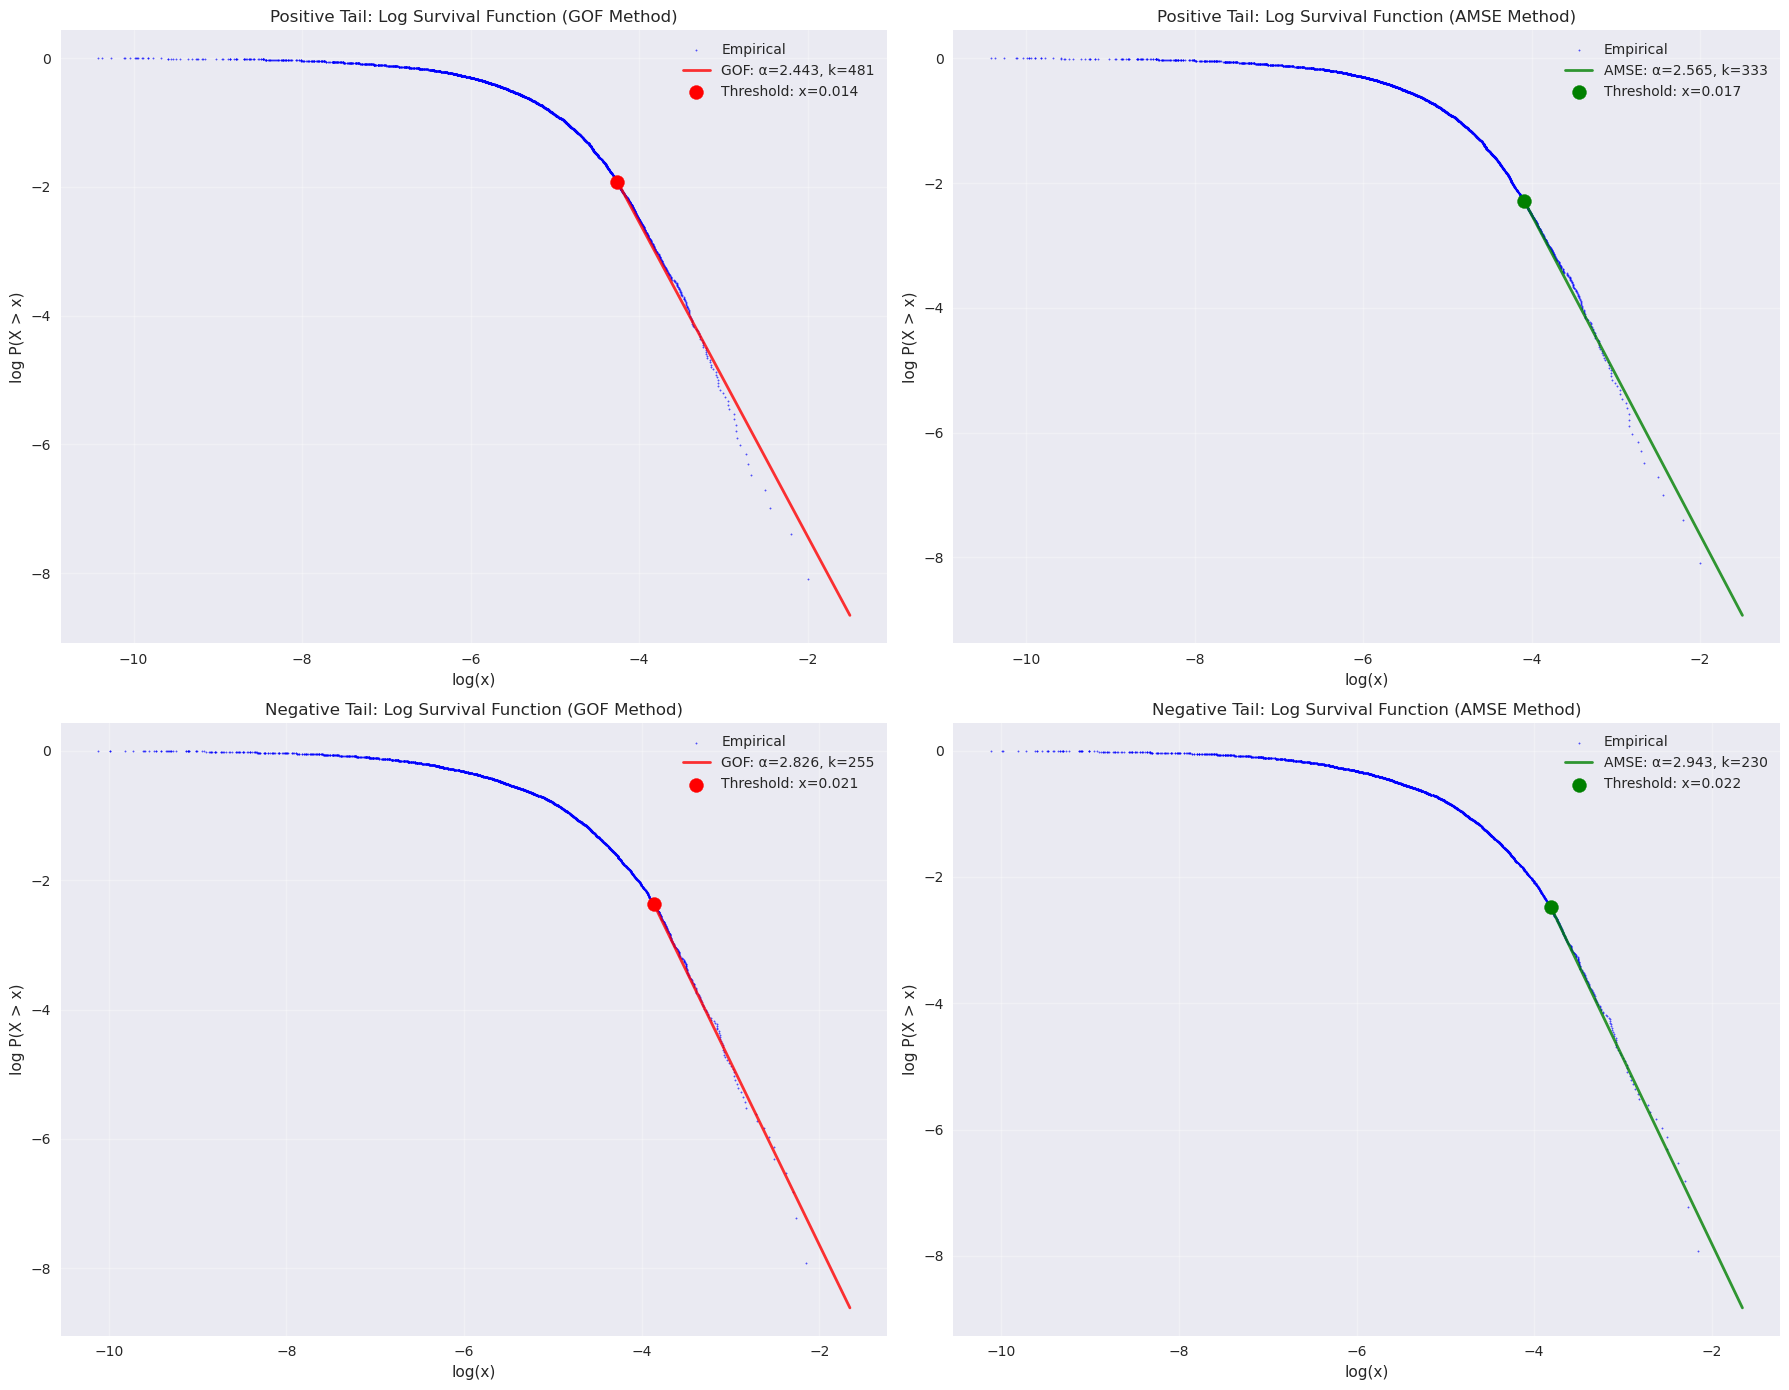

In [7]:
# Create log survival function plots using new plotting function
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

# Positive tail - GOF method
plot_log_survival(
    positive_returns, 
    pos_result_gof, 
    title="Positive Tail: Log Survival Function (GOF Method)",
    ax=ax1
)

# Positive tail - AMSE method
plot_log_survival(
    positive_returns, 
    pos_result_amse, 
    title="Positive Tail: Log Survival Function (AMSE Method)",
    ax=ax2
)

# Negative tail - GOF method
plot_log_survival(
    negative_returns, 
    neg_result_gof, 
    title="Negative Tail: Log Survival Function (GOF Method)",
    ax=ax3
)

# Negative tail - AMSE method
plot_log_survival(
    negative_returns, 
    neg_result_amse, 
    title="Negative Tail: Log Survival Function (AMSE Method)",
    ax=ax4
)

plt.tight_layout()
plt.show()

## 5. Summary Statistics and Interpretation

In [8]:
# Create summary table
summary_data = {
    'Tail': ['Positive (Right)', 'Positive (Right)', 'Negative (Left)', 'Negative (Left)'],
    'Method': ['GOF', 'AMSE', 'GOF', 'AMSE'],
    'k': [pos_result_gof.selection_result.k, pos_result_amse.selection_result.k, 
          neg_result_gof.selection_result.k, neg_result_amse.selection_result.k],
    'γ (Hill)': [pos_result_gof.selection_result.gamma, pos_result_amse.selection_result.gamma,
                neg_result_gof.selection_result.gamma, neg_result_amse.selection_result.gamma],
    'α (Tail Index)': [pos_result_gof.selection_result.alpha, pos_result_amse.selection_result.alpha,
                       neg_result_gof.selection_result.alpha, neg_result_amse.selection_result.alpha],
    'KS Statistic': [pos_result_gof.selection_result.ks_stat, np.nan,
                     neg_result_gof.selection_result.ks_stat, np.nan],
    'AMSE Proxy': [np.nan, pos_result_amse.selection_result.amse_proxy,
                   np.nan, neg_result_amse.selection_result.amse_proxy]
}

summary_df = pd.DataFrame(summary_data)
print("Hill Estimator Results Summary:")
print("=" * 80)
print(summary_df.to_string(index=False, float_format='%.6f'))

print("\n\nInterpretation:")
print("=" * 40)
print(f"• Dataset: SPY ETF daily log returns ({log_returns.index[0].date()} to {log_returns.index[-1].date()})")
print(f"• Total observations: {len(log_returns)}")
print(f"• Positive returns: {len(positive_returns)} ({len(positive_returns)/len(log_returns)*100:.1f}%)")
print(f"• Negative returns: {len(negative_returns)} ({len(negative_returns)/len(log_returns)*100:.1f}%)")
print(f"\n• Tail Index (α):")
print(f"  - Higher α means thinner tails (faster decay)")
print(f"  - Lower α means heavier tails (slower decay)")
print(f"  - Normal distribution has exponentially decaying tails (α → ∞)")
print(f"  - Power law tails have α > 0 and finite")

avg_pos_alpha = (pos_result_gof.selection_result.alpha + pos_result_amse.selection_result.alpha) / 2
avg_neg_alpha = (neg_result_gof.selection_result.alpha + neg_result_amse.selection_result.alpha) / 2

print(f"\n• Results suggest:")
print(f"  - Positive tail: α ≈ {avg_pos_alpha:.2f} (heavy-tailed behavior)")
print(f"  - Negative tail: α ≈ {avg_neg_alpha:.2f} (heavy-tailed behavior)")

if avg_pos_alpha < avg_neg_alpha:
    print(f"  - Positive tail is heavier than negative tail")
else:
    print(f"  - Negative tail is heavier than positive tail")

Hill Estimator Results Summary:
            Tail Method   k  γ (Hill)  α (Tail Index)  KS Statistic  AMSE Proxy
Positive (Right)    GOF 481  0.409416        2.442505      0.033499         NaN
Positive (Right)   AMSE 333  0.389919        2.564632           NaN    0.000599
 Negative (Left)    GOF 255  0.353810        2.826380      0.037405         NaN
 Negative (Left)   AMSE 230  0.339811        2.942809           NaN    0.000502


Interpretation:
• Dataset: SPY ETF daily log returns (2000-01-04 to 2023-12-29)
• Total observations: 6036
• Positive returns: 3273 (54.2%)
• Negative returns: 6036 (100.0%)

• Tail Index (α):
  - Higher α means thinner tails (faster decay)
  - Lower α means heavier tails (slower decay)
  - Normal distribution has exponentially decaying tails (α → ∞)
  - Power law tails have α > 0 and finite

• Results suggest:
  - Positive tail: α ≈ 2.50 (heavy-tailed behavior)
  - Negative tail: α ≈ 2.88 (heavy-tailed behavior)
  - Positive tail is heavier than negative tail

## 6. Model Validation

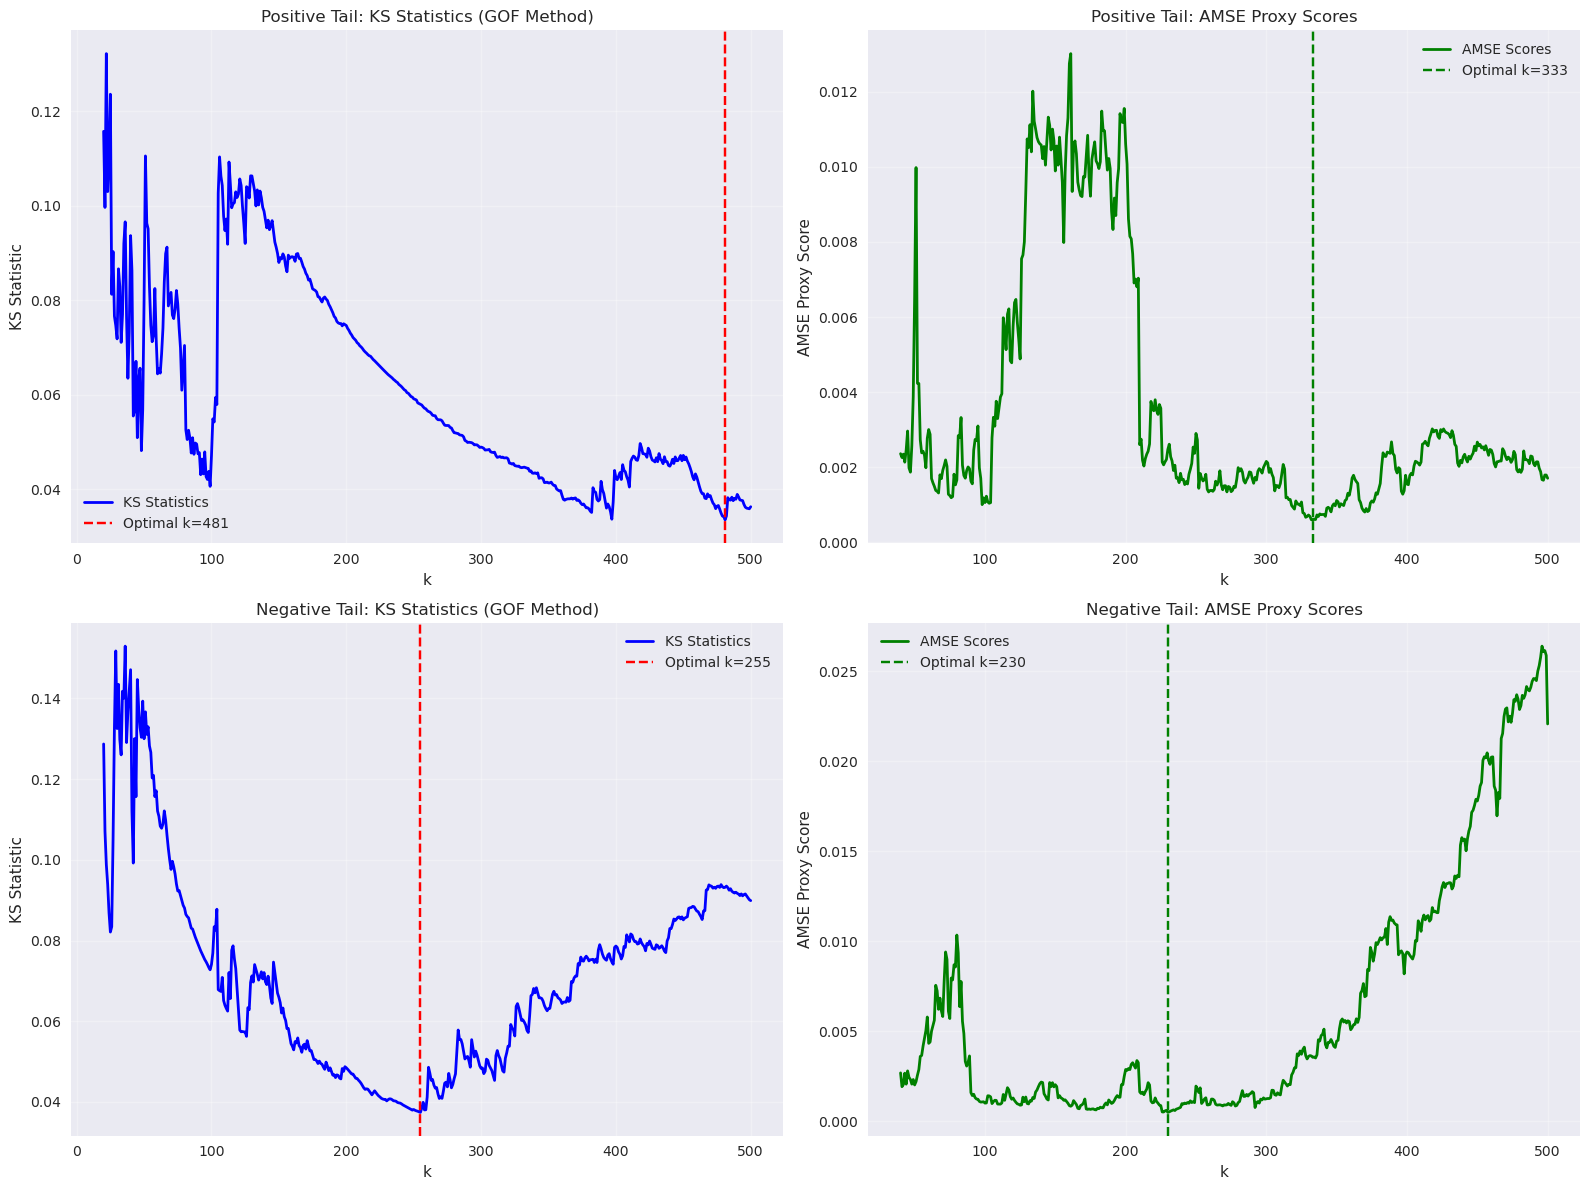

In [9]:
# Plot selection criteria
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# KS statistics for positive tail
k_grid_pos = pos_result_gof.hill_curve.k_grid
ks_stats_pos = pos_result_gof.selection_result.ks_stats

ax1.plot(k_grid_pos, ks_stats_pos, 'b-', linewidth=2, label='KS Statistics')
ax1.axvline(pos_result_gof.selection_result.k, color='red', linestyle='--', 
            label=f"Optimal k={pos_result_gof.selection_result.k}")
ax1.set_xlabel('k')
ax1.set_ylabel('KS Statistic')
ax1.set_title('Positive Tail: KS Statistics (GOF Method)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# AMSE scores for positive tail
amse_scores_pos = pos_result_amse.selection_result.scores
finite_mask = np.isfinite(amse_scores_pos)
ax2.plot(k_grid_pos[finite_mask], amse_scores_pos[finite_mask], 'g-', linewidth=2, label='AMSE Scores')
ax2.axvline(pos_result_amse.selection_result.k, color='green', linestyle='--', 
            label=f"Optimal k={pos_result_amse.selection_result.k}")
ax2.set_xlabel('k')
ax2.set_ylabel('AMSE Proxy Score')
ax2.set_title('Positive Tail: AMSE Proxy Scores')
ax2.legend()
ax2.grid(True, alpha=0.3)

# KS statistics for negative tail
k_grid_neg = neg_result_gof.hill_curve.k_grid
ks_stats_neg = neg_result_gof.selection_result.ks_stats

ax3.plot(k_grid_neg, ks_stats_neg, 'b-', linewidth=2, label='KS Statistics')
ax3.axvline(neg_result_gof.selection_result.k, color='red', linestyle='--', 
            label=f"Optimal k={neg_result_gof.selection_result.k}")
ax3.set_xlabel('k')
ax3.set_ylabel('KS Statistic')
ax3.set_title('Negative Tail: KS Statistics (GOF Method)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# AMSE scores for negative tail
amse_scores_neg = neg_result_amse.selection_result.scores
finite_mask_neg = np.isfinite(amse_scores_neg)
ax4.plot(k_grid_neg[finite_mask_neg], amse_scores_neg[finite_mask_neg], 'g-', linewidth=2, label='AMSE Scores')
ax4.axvline(neg_result_amse.selection_result.k, color='green', linestyle='--', 
            label=f"Optimal k={neg_result_amse.selection_result.k}")
ax4.set_xlabel('k')
ax4.set_ylabel('AMSE Proxy Score')
ax4.set_title('Negative Tail: AMSE Proxy Scores')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()